# Named Entity Recognition (NER) for Twitter Data
**Dataset:** Broad Twitter Corpus (BTC)

In [1]:
!pip install -q datasets nltk sklearn-crfsuite emoji tqdm
# installing the libraries required for the task
# datasets to load the Broad Twitter dataset using HuggingFace datasets
# nltk for NLP preprocessing steps such as POStags, stopword filtering and tokenization
# sklearn-crfsuite for CRF model
# emoji for emoji processing

DEPRECATION: Loading egg at c:\users\pc\anaconda3\envs\text_analytics\lib\site-packages\huggingface_hub-0.29.1-py3.8.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
# importing the required libraies for TASK CRF modelling 
import pandas as pd
import nltk
import string
import re
import emoji
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn_crfsuite import CRF, metrics
from tqdm import tqdm

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to C:\Users\pc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\pc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\pc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pc/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# Loading thw Broad Twitter dataset
# creating dataframes for the train, test and validation data splits
dataset = load_dataset("tner/btc")
train_df = pd.DataFrame(dataset['train'])
valid_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])
# checking the head to check the training data
train_df.head()

,tokens,tags
0,"[I, hate, the, words, chunder, ,, vomit, and, ...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]"
1,"[♥, ., ., ), ), (, ♫, ., (, ړײ, ), ♫, ., ♥, .,...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
2,"[Alesan, kenapa, mlm, kita, lbh, srg, galau, P...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ..."
3,"[Complete, Tosca, on, the, tube, http://t.co/O...","[6, 6, 6, 6, 6, 6]"
4,"[Think, you, call, that, smash, and, grab, ., ...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, ..."


#### POS tagging and Feature Engineering for CRF model 

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
# In each row joiing the tokens to make a sentence and get the Parts-of-Speech tags 
train_df['pos_tags'] = train_df['tokens'].apply(lambda tokens: [token.pos_ for token in nlp(' '.join(tokens))])
valid_df['pos_tags'] = valid_df['tokens'].apply(lambda tokens: [token.pos_ for token in nlp(' '.join(tokens))])
test_df['pos_tags'] = test_df['tokens'].apply(lambda tokens: [token.pos_ for token in nlp(' '.join(tokens))])

#### Token Preprocessing

In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
# As the twitter data contains emojis it iwill create noise intead of removing it we can retain it in the form of words o tokens
# the emojis textual meaning using the emoji library
def convert_emojis(tokens):
    return [emoji.demojize(token).replace(":", "").replace("_", " ") if token in emoji.EMOJI_DATA else token for token in tokens]
def preprocess_tokens(tokens):
    tokens = [token.lower() for token in tokens] #lowercasing and normalization of the text
    tokens = convert_emojis(tokens)  # converted the emojis 
    tokens = [token for token in tokens if token not in stop_words] # removed the stop words like the, and, or etc. 
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # reducing the words to its root fofrm using the lemmatization technique 

    tokens = [token for token in tokens if re.match(r'[A-Za-z]+', token)] # this pny retains the necessary text data and removes the punctuations and other special tokens 
    return tokens
train_df['processed_tokens'] = train_df['tokens'].apply(preprocess_tokens)
valid_df['processed_tokens'] = valid_df['tokens'].apply(preprocess_tokens)
test_df['processed_tokens'] = test_df['tokens'].apply(preprocess_tokens)

#### Feature Extraction

In [7]:
# Feature extraction for the CRF is one of the important NLP steps to acwuire the contextual features
def word2features(sent, i):
    word = sent[i]
    # For each word getting the lexical features 
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True # Beginning boundaryof the sentences

    if i < len(sent)-1:
        word1 = sent[i+1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True # End boundary of the sentences

    return features

# extracting features for all words in a token sequence
def extract_features(tokens):
    return [word2features(tokens, i) for i in range(len(tokens))]
# BIO formatting for NER CRF modellong
def get_labels(entities):
    return entities

In [8]:
# tokens feature extracction for all the datsets train, test and Validation
X_train = [extract_features(s) for s in train_df['tokens']]
y_train = [get_labels(s) for s in train_df['tags']]
X_valid = [extract_features(s) for s in valid_df['tokens']]
y_valid = [get_labels(s) for s in valid_df['tags']]
X_test = [extract_features(s) for s in test_df['tokens']]
y_test = [get_labels(s) for s in test_df['tags']]

In [9]:
# label mapping the dataset features
label_list = dataset['train'].features['tags'].feature.names
def decode_labels(label_ids):
    return [label_list[i] for i in label_ids]
# again apply to the datsets 
y_train = train_df['tags'].apply(decode_labels).tolist()
y_valid = valid_df['tags'].apply(decode_labels).tolist()
y_test = test_df['tags'].apply(decode_labels).tolist()

## CRF Model Training

In [10]:
crf = CRF(algorithm='lbfgs', max_iterations=100, all_possible_transitions=True)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, max_iterations=100)

#### Evaluating on Test data Set

In [11]:
y_pred = crf.predict(X_test)

# Excluding 'O' from the labels so we can get more better results
labels = list(crf.classes_)
if 'O' in labels:
    labels.remove('O')

print("CRF Classification:")
print(metrics.flat_classification_report(y_test, y_pred, labels=labels, digits=3))

correct = sum(p == t for seq_p, seq_t in zip(y_pred, y_test) for p, t in zip(seq_p, seq_t))
total = sum(len(seq) for seq in y_test)
accuracy = correct / total
print("Token-level Accuracy:", round(accuracy, 4))

CRF Classification:
              precision    recall  f1-score   support

       B-LOC      0.765     0.395     0.521       636
       B-PER      0.796     0.816     0.806      2650
       B-ORG      0.599     0.237     0.339      1090
       I-ORG      0.474     0.301     0.368       246
       I-PER      0.608     0.662     0.633       269
       I-LOC      0.654     0.337     0.444       208

   micro avg      0.743     0.587     0.656      5099
   macro avg      0.649     0.458     0.519      5099
weighted avg      0.719     0.587     0.626      5099

Token-level Accuracy: 0.9343


In [12]:
# perfroming the CRF on the test data and classifying on LOC, ORG and PER 

def convert_to_coarse_tags(tag_sequence):
    return [tag.split('-')[-1] if tag != 'O' else tag for tag in tag_sequence]

from sklearn_crfsuite import metrics as crf_metrics
y_pred = crf.predict(X_test)

def decode_labels(tags): return [label_list[t] for t in tags]
y_test = [decode_labels(seq) for seq in test_df['tags']]

y_test_coarse = [convert_to_coarse_tags(seq) for seq in y_test]
y_pred_coarse = [convert_to_coarse_tags(seq) for seq in y_pred]
# Excluded the 'O' labels
def filter_out_O(y_true, y_pred):
    y_true_filtered, y_pred_filtered = [], []
    for t_seq, p_seq in zip(y_true, y_pred):
        filtered_t = []
        filtered_p = []
        for t, p in zip(t_seq, p_seq):
            if t != 'O':
                filtered_t.append(t)
                filtered_p.append(p)
        if filtered_t:
            y_true_filtered.append(filtered_t)
            y_pred_filtered.append(filtered_p)
    return y_true_filtered, y_pred_filtered

y_test_filtered, y_pred_filtered = filter_out_O(y_test_coarse, y_pred_coarse)


# only LOC, ORG and PER for the task as required 
labels = ['LOC', 'ORG', 'PER']  
print("Classification Report CRF:")
print(crf_metrics.flat_classification_report(
    y_test_filtered, y_pred_filtered, labels=labels, digits=3
))

correct = sum(p == t for seq_p, seq_t in zip(y_pred_coarse, y_test_coarse) for p, t in zip(seq_p, seq_t))
total = sum(len(seq) for seq in y_test_coarse)
accuracy = correct / total
print(f"\nToken-level Accuracy: {accuracy:.4f}")


Classification Report CRF:
              precision    recall  f1-score   support

         LOC      0.830     0.386     0.527       844
         ORG      0.683     0.258     0.375      1336
         PER      0.814     0.811     0.812      2919

   micro avg      0.798     0.596     0.682      5099
   macro avg      0.775     0.485     0.571      5099
weighted avg      0.782     0.596     0.650      5099


Token-level Accuracy: 0.9355


In [13]:
# example of the tokens and their BIO-encoded tags
example_index = 200 # any row
example_tokens = train_df['tokens'][example_index]
example_tags = decode_labels(train_df['tags'][example_index])
print("Example Entity Span (BIO):")
for token, tag in zip(example_tokens, example_tags):
    print(f"{token:<12} -> {tag}")

Example Entity Span (BIO):
It           -> O
's           -> O
like         -> O
this         -> O
Hunico       -> B-PER
/            -> I-PER
TedDiBiase   -> O
match        -> O
did          -> O
n't          -> O
happen       -> O
.            -> O
Cole         -> B-PER
&            -> O
Josh         -> B-PER
did          -> O
n't          -> O
even         -> O
call         -> O
it           -> O
,            -> O
they         -> O
just         -> O
spoke        -> O
over         -> O
it           -> O
with         -> O
nonsense     -> O
#            -> O
wwe          -> B-ORG


In [15]:
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report as sk_class_report

report = flat_classification_report(y_test_filtered, y_pred_filtered, labels=['LOC', 'ORG', 'PER'], digits=3, output_dict=True)
crf_results_df = pd.DataFrame(report).T
crf_results_df = crf_results_df[['precision', 'recall', 'f1-score']]
crf_results_df.drop(index=['micro avg', 'macro avg', 'weighted avg', 'samples avg'], errors='ignore', inplace=True)
print("CRF Evaluation Table:")
display(crf_results_df)

CRF Evaluation Table:


,precision,recall,f1-score
LOC,0.829517,0.386256,0.527082
ORG,0.683168,0.258234,0.374796
PER,0.813682,0.810894,0.812286


In [ ]:
print("\nExample of CRF Misclassification:")
for i, (true_seq, pred_seq, tokens) in enumerate(zip(y_test_filtered, y_pred_filtered, test_df['tokens'])):
    if true_seq != pred_seq:
        print(f"Tokens       : {tokens}")
        print(f"True Labels  : {true_seq}")
        print(f"Pred Labels  : {pred_seq}")
        break


Example of CRF Misclassification:
Tokens       : ['This', 'morning', 'I', 'met', 'with', 'Senators', 'Inabo', 'and', 'Senior', 'from', 'Palau', 'to', 'discuss', 'my', 'role', 'as', 'Chair', 'of', 'the', 'Public', 'Works', '.', '.', '.', 'http://t.co/McYNwpzHmt']
True Labels  : ['PER', 'PER', 'LOC']
Pred Labels  : ['ORG', 'O', 'LOC']


In [17]:
# the processed tokens used in the CRF model

def print_processed_tokens(dataset_split, num_examples=5):
    print("\nProcessed Tokens Used for CRF Feature Extraction:\n")
    for i in range(num_examples):
        print(f"Example {i+1}:")
        print(dataset_split['processed_tokens'].iloc[i])
        print("-" * 50)

print_processed_tokens(train_df, num_examples=5)


Processed Tokens Used for CRF Feature Extraction:

Example 1:
['hate', 'word', 'chunder', 'vomit', 'puke', 'buuh']
--------------------------------------------------
Example 2:
['heart suit', 'heart suit', 'heart suit', 'happy', 'new', 'year']
--------------------------------------------------
Example 3:
['alesan', 'kenapa', 'mlm', 'kita', 'lbh', 'srg', 'galau', 'poconggg', 'twitfakta', 'otak', 'lebih', 'aktif', 'di', 'malam', 'hari', 'dari', 'pada', 'di', 'pagi', 'hari', 'twitfakta']
--------------------------------------------------
Example 4:
['complete', 'tosca', 'tube', 'http://t.co/o90deslb']
--------------------------------------------------
Example 5:
['think', 'call', 'smash', 'grab', 'gateshead', 'medium', 'man', 'admitted', 'daylight', 'robbery', 'shaw', 'touch', 'goal']
--------------------------------------------------


In [18]:
import re
# finding the correctly predicted tokens for each entity type toaddress the misclassification
def print_correct_predictions_by_entity(entity_type, y_true, y_pred, tokens_list, num_examples=5):
   
    count = 0
    special_token_pattern = re.compile(r'^[a-zA-Z]+$') 
    print(f"\nCorrectly Predicted Tokens for {entity_type}:\n")
    for true_seq, pred_seq, tokens in zip(y_true, y_pred, tokens_list):
        for token, true_label, pred_label in zip(tokens, true_seq, pred_seq):
            if (true_label == entity_type) and (pred_label == entity_type) and special_token_pattern.match(token):
                print(f"Token: {token}, True Label: {true_label}, Predicted Label: {pred_label}")
                count += 1
                if count >= num_examples:
                    return

print_correct_predictions_by_entity('PER', y_test_coarse, y_pred_coarse, test_df['tokens'], num_examples=5)
print_correct_predictions_by_entity('ORG', y_test_coarse, y_pred_coarse, test_df['tokens'], num_examples=5)
print_correct_predictions_by_entity('LOC', y_test_coarse, y_pred_coarse, test_df['tokens'], num_examples=5)


Correctly Predicted Tokens for PER:

Token: colgo, True Label: PER, Predicted Label: PER
Token: alisoncroggon, True Label: PER, Predicted Label: PER
Token: AmandaRishworth, True Label: PER, Predicted Label: PER
Token: Robin, True Label: PER, Predicted Label: PER
Token: Williams, True Label: PER, Predicted Label: PER

Correctly Predicted Tokens for ORG:

Token: New, True Label: ORG, Predicted Label: ORG
Token: York, True Label: ORG, Predicted Label: ORG
Token: Times, True Label: ORG, Predicted Label: ORG
Token: ADF, True Label: ORG, Predicted Label: ORG
Token: NTThunderFC, True Label: ORG, Predicted Label: ORG

Correctly Predicted Tokens for LOC:

Token: Palau, True Label: LOC, Predicted Label: LOC
Token: Aston, True Label: LOC, Predicted Label: LOC
Token: Parlt, True Label: LOC, Predicted Label: LOC
Token: Australia, True Label: LOC, Predicted Label: LOC
Token: Canberra, True Label: LOC, Predicted Label: LOC


In [19]:
# entity span undersanding about the BIO tagging 
def extract_entity_spans(tokens, tags):
    span = []
    current_entity = None
    for token, tag in zip(tokens, tags):
        if tag.startswith("B-"):
            if span:
                print(f"Entity: {' '.join(span)} | Type: {current_entity}")
                span = []
            current_entity = tag[2:]
            span = [token]
        elif tag.startswith("I-") and current_entity == tag[2:]:
            span.append(token)
        else:
            if span:
                print(f"Entity: {' '.join(span)} | Type: {current_entity}")
                span = []
            current_entity = None
    if span:
        print(f"Entity: {' '.join(span)} | Type: {current_entity}")

In [20]:
tokens = ['New', 'York', 'Times', 'is', 'great', 'and', 'Barack', 'Obama', 'was', 'there']
tags = ['B-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O']
extract_entity_spans(tokens, tags)

Entity: New York Times | Type: ORG
Entity: Barack Obama | Type: PER


# BiLSTM + CRF for Named Entity Recognition

In [ ]:
!pip install -q torch torchcrf seqeval 
# Torch is needed for the BiLSTM model training
# torchcrf for the CRF Layer which is on top of the BiLSTM model
# seqeval for perfromance metrics 

DEPRECATION: Loading egg at c:\users\pc\anaconda3\envs\text_analytics\lib\site-packages\huggingface_hub-0.29.1-py3.8.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [22]:
# Libraries required for the BiLST+ CRF modelling 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from seqeval.metrics import classification_report
from nltk import pos_tag

In [24]:
dataset = load_dataset("tner/btc")

# 
label_list = dataset['train'].features['tags'].feature.names

# this function is necesary for later on steps - it converts numerical tag IDs to BIO formatting
# we need this for the viewing the seqeval predictions as it is showing error for the numerical IDs 
# Also helped to see the BIO tagging and help understand the classes or the labelling of the tokens 
def decode_labels(tags): return [label_list[tag] for tag in tags]

# created new dataframs for this model to avoid confusion
train_tokens = dataset['train']['tokens']
train_labels = [decode_labels(x) for x in dataset['train']['tags']]
val_tokens = dataset['validation']['tokens']
val_labels = [decode_labels(x) for x in dataset['validation']['tags']]
test_tokens = dataset['test']['tokens']
test_labels = [decode_labels(x) for x in dataset['test']['tags']]

In [ ]:
from collections import Counter

#  creating the word vocabulary
#  case folding - lowercasing  similar to the CRF model
all_words = [w.lower() for sent in train_tokens for w in sent]
word_counter = Counter(all_words) # number of words 
vocab = ["<PAD>", "<UNK>"] + [w for w, c in word_counter.items() if c > 1]
# word-to-index mapping dictionary
word2idx = {w: i for i, w in enumerate(vocab)}

# Character level vocabulary extrcation
all_chars = set(c for w in vocab for c in w)
char2idx = {c: i+1 for i, c in enumerate(all_chars)} 
char2idx["<PAD>"] = 0

# Again this is an important step to tag the indexes to the labels or BIO tags
tag2idx = {t: i for i, t in enumerate(label_list)}
idx2tag = {i: t for t, i in tag2idx.items()}

#### GloVe Embeddings

In [26]:
import numpy as np
def load_glove(path, word2idx, dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), dim))
    embeddings[word2idx["<PAD>"]] = np.zeros(dim)
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            # vector representation for the words
            if word in word2idx:
                vector = np.array(parts[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings).float()

# downloaded file - glove embedding 100 dimentional vector representation
glove_path = r'C:\Users\pc\Desktop\Text Aalytics Twitter\glove.6B.100d.txt'
# embedding matrix
embedding_matrix = load_glove(glove_path, word2idx, dim=100)

#### Encoding Tokens, Tags, Characters, and POS Tags

In [28]:
# here we are coverting bio format strings to Numeric ID for training our model for pytorch and CRF 
def encode_tokens(tokens, word2idx, max_len):
    return [word2idx.get(w.lower(), word2idx["<UNK>"]) for w in tokens[:max_len]] +  [word2idx["<PAD>"]] * (max_len - len(tokens))

def encode_tags(tags, tag2idx, max_len):
    return [tag2idx[t] for t in tags[:max_len]] + [tag2idx["O"]] * (max_len - len(tags))

def encode_chars(tokens, char2idx, max_len, max_char_len=15):
    char_ids = []
    # padding the tokens to max length
    for word in tokens[:max_len]:
        chars = [char2idx.get(c, 0) for c in word[:max_char_len]]
        chars += [0] * (max_char_len - len(chars))
        char_ids.append(chars)
    for _ in range(max_len - len(char_ids)):
        char_ids.append([0]*max_char_len)
    return char_ids

def encode_pos(tokens, max_len):
    tags = [tag for _, tag in pos_tag(tokens[:max_len])]
    tag2id = {tag: i+1 for i, tag in enumerate(set(tags))}
    encoded = [tag2id[t] for t in tags]
    return encoded + [0] * (max_len - len(encoded))

### NER Dataset - preprocessing and encoding functions

In [30]:
#   named entity recognition datset to preprocess and encoding functions 
class NERDataset(Dataset):
    def __init__(self, tokens, labels, word2idx, tag2idx, char2idx, max_len=50):
        self.tokens = tokens
        self.labels = labels
        self.word2idx = word2idx
        self.tag2idx = tag2idx
        self.char2idx = char2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        words = self.tokens[idx]
        tags = self.labels[idx]
        x = encode_tokens(words, self.word2idx, self.max_len)
        y = encode_tags(tags, self.tag2idx, self.max_len)
        c = encode_chars(words, self.char2idx, self.max_len)
        p = encode_pos(words, self.max_len)

        return torch.tensor(x), torch.tensor(y), torch.tensor(c), torch.tensor(p)

In [ ]:
max_len = 64

batch_size = 32

train_set = NERDataset(train_tokens, train_labels, word2idx, tag2idx, char2idx, max_len)
val_set = NERDataset(val_tokens, val_labels, word2idx, tag2idx, char2idx, max_len)
test_set = NERDataset(test_tokens, test_labels, word2idx, tag2idx, char2idx, max_len)

train_loader = DataLoader(train_set, batch_size=batch_size)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

In [33]:
from torchcrf import CRF

class BiLSTM_CRF_Model(nn.Module):

    # word embedding, character embedding, CNN for char features, 
    # LSTM for sequence modelling, and CRF for decoding
    def __init__(self, word_vocab_size, char_vocab_size, tagset_size, embedding_matrix, hidden_dim=128, char_dim=30, max_char_len=15):
        super().__init__()
        self.word_emb = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.char_emb = nn.Embedding(char_vocab_size, char_dim, padding_idx=0)
        self.char_cnn = nn.Conv1d(char_dim, 30, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(embedding_matrix.size(1) + 30, hidden_dim // 2, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)
        self.crf = CRF(tagset_size)
        self.max_char_len = max_char_len

    # this function does forward Pass: Embeddings → LSTM 

    def forward(self, x_w, x_c, mask):
        w_emb = self.word_emb(x_w)
        b, l, c = x_c.shape
        c_emb = self.char_emb(x_c.view(b*l, c)).permute(0, 2, 1)
        c_feat = self.char_cnn(c_emb).max(dim=2)[0].view(b, l, -1)
        feats = torch.cat([w_emb, c_feat], dim=2)
        lstm_out, _ = self.lstm(feats)
        emissions = self.fc(lstm_out)
        return emissions
    
    # log-likelihood for CRF layer function 
    def loss(self, x_w, x_c, y, mask):
        emissions = self.forward(x_w, x_c, mask)
        return -self.crf(emissions, y, mask=mask).mean()  
    
    # CRF Viterbi Decoding

    def predict(self, x_w, x_c, mask):
        emissions = self.forward(x_w, x_c, mask)
        
        # masking boolean format for emmissions
        if mask.dtype != torch.bool:
            mask = mask.bool()
        # returning the prediction of best tag sequence using CRF decoding
        return self.crf.viterbi_decode(emissions, mask)

### Training for BiLSTM + CRF Model

In [34]:
def train(model, loader, optimizer, epochs=5):
    for e in range(epochs):
        model.train()
        total_loss = 0
        for x, y, c, p in tqdm(loader):  
            mask = x != word2idx["<PAD>"]
            loss = model.loss(x, c, y, mask)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {e+1} Loss: {total_loss:.4f}")

### Evaluation Function using Seqeval

In [35]:
from seqeval.metrics import classification_report, accuracy_score
def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y, c, p in loader:  
            mask = x != word2idx["<PAD>"]
            preds = model.predict(x, c, mask)
            for i in range(len(x)):
                true = [idx2tag[t.item()] for t, m in zip(y[i], mask[i]) if m]
                pred = [idx2tag[t] for t in preds[i]]
                y_true.append(true)
                y_pred.append(pred)

    print("Classification Report BiLSTM + CRF:")            
    print(classification_report(y_true, y_pred))
    acc = accuracy_score(y_true, y_pred)
    print(f"\nToken-level Accuracy: {acc:.4f}")

### Executing the BiLSTM + CRF model 

In [36]:
model = BiLSTM_CRF_Model(len(word2idx), len(char2idx), len(tag2idx), embedding_matrix)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, optimizer, epochs=5)
evaluate(model, test_loader)

100%|██████████| 199/199 [00:17<00:00, 11.65it/s]


Epoch 1 Loss: 1531.3741


100%|██████████| 199/199 [00:17<00:00, 11.09it/s]


Epoch 2 Loss: 837.2660


100%|██████████| 199/199 [00:19<00:00, 10.30it/s]


Epoch 3 Loss: 614.4080


100%|██████████| 199/199 [00:22<00:00,  8.74it/s]


Epoch 4 Loss: 492.2237


100%|██████████| 199/199 [00:23<00:00,  8.55it/s]


Epoch 5 Loss: 414.6241
Classification Report BiLSTM + CRF:
              precision    recall  f1-score   support

         LOC       0.68      0.36      0.47       636
         ORG       0.50      0.23      0.32      1090
         PER       0.75      0.87      0.81      2650

   micro avg       0.71      0.64      0.67      4376
   macro avg       0.64      0.49      0.53      4376
weighted avg       0.68      0.64      0.64      4376


Token-level Accuracy: 0.9371


In [ ]:
# entiy span in this model
example_index = 3
tokens = train_tokens[example_index]
tags = train_labels[example_index]

print("Example Entity Span (BIO):")
for token, tag in zip(tokens, tags):
    print(f"{token:<12} -> {tag}")

Example Entity Span (BIO):
Complete     -> O
Tosca        -> O
on           -> O
the          -> O
tube         -> O
http://t.co/O90deSLB -> O


In [38]:
#predictions and ground truths from BiLSTM+CRF
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for x, y, c, p in test_loader:
        mask = x != word2idx["<PAD>"]
        preds = model.predict(x, c, mask)
        for i in range(len(x)):
            true = [idx2tag[t.item()] for t, m in zip(y[i], mask[i]) if m]
            pred = [idx2tag[t] for t in preds[i]]
            y_true.append(true)
            y_pred.append(pred)

In [39]:
from seqeval.metrics import classification_report
from seqeval.metrics import classification_report as seqeval_report
import pandas as pd

# classification report for this model
bilstm_report_dict = classification_report(y_true, y_pred, output_dict=True)
bilstm_results_df = pd.DataFrame(bilstm_report_dict).T
bilstm_results_df = bilstm_results_df[['precision', 'recall', 'f1-score']]
bilstm_results_df.drop(index=['micro avg', 'macro avg', 'weighted avg'], errors='ignore', inplace=True)

print("BiLSTM + CRF Evaluation Table:")
display(bilstm_results_df)


BiLSTM + CRF Evaluation Table:


,precision,recall,f1-score
LOC,0.684524,0.361635,0.473251
ORG,0.498054,0.234862,0.319202
PER,0.751460,0.873962,0.808095


In [ ]:
print("Example of BiLSTM+CRF Misclassification:")
for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:
        print(f"\nTokens       : {test_tokens[i]}")
        print(f"True Labels  : {y_true[i]}")
        print(f"Pred Labels  : {y_pred[i]}")
        break

Example of BiLSTM+CRF Misclassification:

Tokens       : ['This', 'morning', 'I', 'met', 'with', 'Senators', 'Inabo', 'and', 'Senior', 'from', 'Palau', 'to', 'discuss', 'my', 'role', 'as', 'Chair', 'of', 'the', 'Public', 'Works', '.', '.', '.', 'http://t.co/McYNwpzHmt']
True Labels  : ['O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'B-PER', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels  : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## TinyBERT

In [41]:
!pip install -q transformers datasets seqeval torch accelerate
# installing the nexesary packages for the TinyBERT model for the NER 

DEPRECATION: Loading egg at c:\users\pc\anaconda3\envs\text_analytics\lib\site-packages\huggingface_hub-0.29.1-py3.8.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [43]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification, TrainingArguments, Trainer
from seqeval.metrics import classification_report
import numpy as np

# once again loading the dataset for the TinyBERT model
btc = load_dataset("tner/btc")
label_list = btc["train"].features["tags"].feature.names
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in enumerate(label_list)}
num_labels = len(label_list)

# tokenizer for Tiny BERT
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        aligned_labels = []
        prev_word_id = None
        for word_id in word_ids:
            if word_id is None:
                aligned_labels.append(-100)
            elif word_id != prev_word_id:
                aligned_labels.append(label[word_id])
            else:
                aligned_labels.append(-100)
            prev_word_id = word_id
        labels.append(aligned_labels)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# the tokenized data
tokenized_datasets = btc.map(tokenize_and_align_labels, batched=True)
data_collator = DataCollatorForTokenClassification(tokenizer)

# Loading the "prajjwal1/bert-tiny" tinybert for modelling
model = AutoModelForTokenClassification.from_pretrained(
    "prajjwal1/bert-tiny", 
    num_labels=num_labels, 
    id2label=id2label, 
    label2id=label2id
)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
from seqeval.metrics import classification_report
# here we are defining the computing the metrixs for the classification report for the TinyBERT model
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    print("Classification Report for TinyBERT:")
    print(classification_report(true_labels, true_predictions))
    return {
        "precision": classification_report(true_labels, true_predictions, output_dict=True)["weighted avg"]["precision"],
        "recall": classification_report(true_labels, true_predictions, output_dict=True)["weighted avg"]["recall"],
        "f1": classification_report(true_labels, true_predictions, output_dict=True)["weighted avg"]["f1-score"],
    }

In [46]:
# Training the TinyBERT Model using 5 epochs 
args = TrainingArguments(
    output_dir="tinybert-btc-ner",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=20,
    load_best_model_at_end=True,
    report_to="none"
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset = tokenized_datasets["train"], 
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
trainer.train()

C:\Users\pc\AppData\Local\Temp\ipykernel_35952\3837342338.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.386100,0.309184,0.511844,0.515607,0.501930
2,0.339200,0.273120,0.623220,0.531792,0.530990
3,0.278200,0.248536,0.665381,0.577457,0.560566
4,0.288100,0.246562,0.637005,0.565318,0.567030
5,0.202600,0.243664,0.646460,0.571676,0.573592


Classification Report for TinyBERT:


c:\Users\pc\anaconda3\envs\text_analytics\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         LOC       0.47      0.10      0.16       156
         ORG       0.00      0.00      0.00       380
         PER       0.68      0.73      0.71      1194

   micro avg       0.68      0.52      0.58      1730
   macro avg       0.38      0.28      0.29      1730
weighted avg       0.51      0.52      0.50      1730

Classification Report for TinyBERT:
              precision    recall  f1-score   support

         LOC       0.48      0.23      0.31       156
         ORG       0.44      0.02      0.04       380
         PER       0.70      0.73      0.72      1194

   micro avg       0.69      0.53      0.60      1730
   macro avg       0.54      0.33      0.35      1730
weighted avg       0.62      0.53      0.53      1730

Classification Report for TinyBERT:
              precision    recall  f1-score   support

         LOC       0.47      0.27      0.34       156
         ORG       0.62      0.04      0.07       380
   

TrainOutput(global_step=3965, training_loss=0.3112707640153613, metrics={'train_runtime': 232.8124, 'train_samples_per_second': 136.118, 'train_steps_per_second': 17.031, 'total_flos': 3565420121496.0, 'train_loss': 0.3112707640153613, 'epoch': 5.0})

In [47]:
# here we are defining the computing the metrixs for the classification report for the TinyBERT model
# Filtering out 'O' taht is the other entities labels from both y_true and y_pred
def filter_out_O(y_true, y_pred):
    new_y_true, new_y_pred = [], []
    for t_seq, p_seq in zip(y_true, y_pred):
        filtered_t, filtered_p = [], []
        for t, p in zip(t_seq, p_seq):
            if t != 'O':
                filtered_t.append(t)
                filtered_p.append(p)
        if filtered_t:  # ensure we don't add empty rows
            new_y_true.append(filtered_t)
            new_y_pred.append(filtered_p)
    return new_y_true, new_y_pred
filtered_true, filtered_pred = filter_out_O(y_true, y_pred)

# Run evaluation without 'O'
print("Classification Report TinyBERT:")
print(classification_report(filtered_true, filtered_pred, digits=3))

Classification Report TinyBERT:
              precision    recall  f1-score   support

         LOC      0.755     0.363     0.490       636
         ORG      0.633     0.236     0.344      1090
         PER      0.776     0.876     0.823      2650

   micro avg      0.759     0.642     0.696      4376
   macro avg      0.721     0.492     0.552      4376
weighted avg      0.738     0.642     0.655      4376



In [48]:
# example of the entity spans for this model
example_index = 3
tokens = btc['train']['tokens'][example_index]
labels = btc['train']['tags'][example_index]
bio_tags = [label_list[t] for t in labels]
for token, tag in zip(tokens, bio_tags):
    print(f"{token:<12} -> {tag}")

Complete     -> O
Tosca        -> O
on           -> O
the          -> O
tube         -> O
http://t.co/O90deSLB -> O


In [49]:
print("Example of Tiny BERT Misclassification:")
for i in range(len(filtered_true)):
    if filtered_true[i] != filtered_pred[i]:
        print(f"\nTokens       : {btc['test']['tokens'][i]}")
        print(f"True Labels  : {filtered_true[i]}")
        print(f"Pred Labels  : {filtered_pred[i]}")
        break


Example of Tiny BERT Misclassification:

Tokens       : ['This', 'morning', 'I', 'met', 'with', 'Senators', 'Inabo', 'and', 'Senior', 'from', 'Palau', 'to', 'discuss', 'my', 'role', 'as', 'Chair', 'of', 'the', 'Public', 'Works', '.', '.', '.', 'http://t.co/McYNwpzHmt']
True Labels  : ['B-PER', 'B-PER', 'B-LOC']
Pred Labels  : ['O', 'O', 'B-LOC']


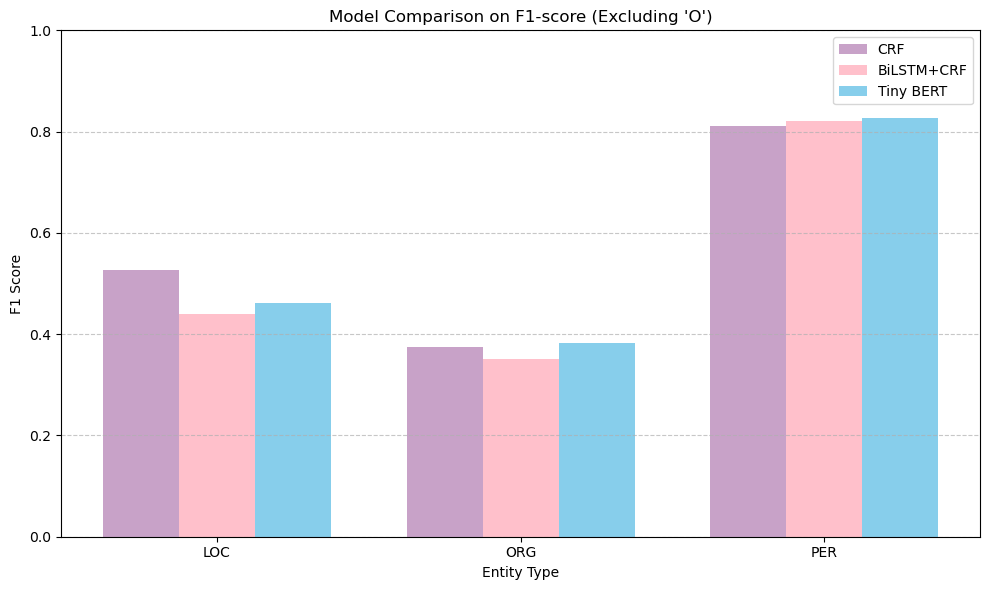

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

# F1 scores for each model per entity
data = {
    "Entity": ["LOC", "ORG", "PER"],
    "CRF": [0.527, 0.375, 0.812],
    "BiLSTM+CRF": [0.44, 0.35, 0.82],
    "Tiny BERT": [0.461, 0.383, 0.827]
}
df = pd.DataFrame(data)

bar_width = 0.25
x = range(len(df["Entity"]))

# plotiing a bar chart for all the models with the F1 Scores as the performance metrics
plt.figure(figsize=(10, 6))
plt.bar([p - bar_width for p in x], df["CRF"], width=bar_width, label="CRF", color='#C8A2C8') 
plt.bar(x, df["BiLSTM+CRF"], width=bar_width, label="BiLSTM+CRF", color='#FFC0CB') 
plt.bar([p + bar_width for p in x], df["Tiny BERT"], width=bar_width, label="Tiny BERT", color='#87CEEB')

# Add labels and formatting
plt.xlabel("Entity Type")
plt.ylabel("F1 Score")
plt.title("Model Comparison on F1-score (Excluding 'O')")
plt.xticks(ticks=x, labels=df["Entity"])
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()